# Testing the 'Flow Matching in 100 LOC'-code and augmenting it with Bayesian Methods

In [1]:
import torch

import sys
sys.path.append('./src/')
sys.path.append('./src/models/')

from cond_CFM import CNF

import numpy as np
import os
from tqdm import tqdm

from models.custom_linear_flipout import custom_LinearFlipout as LinearFlipout, Flipout_Dropout, LinearDropout

from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import pickle

In [2]:
from src.utils import *
from src.dataloader import *
from src.plot_util import *

In [3]:
def mkdir(save_dir):
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    return save_dir

def smooth(x, kernel_size=5):
    if kernel_size == 1:
        return x
    else:
        assert kernel_size % 2 != 0
        x_shape = x.shape
        x_tmp = np.array([x[i:x_shape[0]-kernel_size+i+1] for i in range(kernel_size)])
        edge1 = x[:int((kernel_size-1)/2)]
        edge2 = x[-int((kernel_size-1)/2):]
        x_out = np.concatenate((edge1, np.mean(x_tmp, 0),edge2),0)
        assert x_shape == x_out.shape
        return x_out #np.mean(np.array(x).reshape(-1, kernel_size),1)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [5]:
############
### data ###
############

r_test = 4.0
n_samples = 10_000
data_dim = 2 #5
donut_shape = "donut_gamma"
add_str_save = ''

data_path = './data/' 

#donut_args = {'u_mean':0, 'u_sigma':1, 'r_mean': 4.0, 'r_sigma': 1, 'm_cut': 'inf', 'gamma_scale': 2.}
#sampler = multidim_sampler(data_dim, "donut_gamma", save_path = data_path, **donut_args)
donut_args = {'u_mean':0, 'u_sigma':1, 'r_mean': 4.0, 'r_sigma': 1, 'm_cut': 'inf', 'gamma_scale': 2.}
sampler = multidim_sampler(data_dim, donut_shape, save_path = data_path, **donut_args)

In [6]:
#################################################
### calculate quantiles or set histogram bins ###
#################################################

z = torch.randn(5_000_000, data_dim).to(device)
c = r_test*torch.ones((len(z),1)).to(device)

linear = False #True
n_bins_array = np.array([50]) if linear else np.array([5,10,50]) 

name_add = '_linear' if linear else ''
quant_list_list_name = f'quant_list_list_{donut_args["gamma_scale"]}gamma{name_add}.pkl'
quant_list_list_path = f'./figs/' + quant_list_list_name

if not quant_list_list_name in os.listdir('./figs/'):
    data_true = cart_to_nsphere(sampler.sample_data(10_000_000)[0])
    quant_list_list = []
    for n_quantile in tqdm(n_bins_array):
        if linear:
            quant_list = (np.linspace(2,6,n_quantile), np.linspace(0,2*np.pi,n_quantile))
        else:
            quant_list = quantiles(data_true, n_quantile, verbose = False)
            quant_list = (np.concatenate((np.asarray([-100]), np.asarray(quant_list[0]), np.asarray([100])), 0),
                        np.concatenate((np.asarray([0]), np.asarray(quant_list[1]), np.asarray([2*np.pi])), 0))
        quant_list_list.append(quant_list)
    del data_true
    with open(quant_list_list_path, 'wb') as f:
        pickle.dump(quant_list_list, f)
else:
    with open(quant_list_list_path, 'rb') as file: 
        quant_list_list = pickle.load(file) 

In [7]:
####################
### model params ###
####################

approximate_gaussian_inference = False #False
MCMC = approximate_gaussian_inference == False

p = 0
n_nodes = 32
n_layers = 3

c_factor = 100.
#c_factor = .0001
ep = 250000 if approximate_gaussian_inference else None

n_stat_epis = 10 #if approximate_gaussian_inference else MCMC_samples
save_every = 100

if approximate_gaussian_inference:
    save_dir = mkdir(f'./models/CFM_VIB_k{c_factor}_cond')
else:
    save_dir = mkdir(f'./models/CFM_cond')
#save_dir = mkdir(mkdir(save_dir + f'/donut_{data_dim}d{add_str_save}_{donut_args["r_mean"]}rmean_{donut_args["gamma_scale"]}gamma/')+f'{n_samples}pts/')
save_dir = mkdir(mkdir(save_dir + f'/{donut_shape}_{data_dim}d{add_str_save}_{donut_args["r_mean"]}rmean_{donut_args["gamma_scale"]}gamma/')+f'{n_samples}pts/')
m_list_dir = save_dir

In [8]:
#################################
### calculate quantile values ###
#################################

n_reps = range(0,5)
calc = False

if calc:
    for n_mod in n_reps:
        m_list_dir =  save_dir + f'/{n_mod}/' 
        if MCMC:
            m_list_dir += '/AdamMCMC_models/' 
            m_list_dir += '0.5sigma_1.0temp_0.001lr_50.0sigma_adam_dir_denom/'
        quantvals_nstatepis = []

        if approximate_gaussian_inference:
            if p != 0:
                model = CNF(data_dim, conds = 1, hidden_features=[n_nodes] * n_layers, layer = Flipout_Dropout, layer_kwargs={'p': p})
            else:
                model = CNF(data_dim, conds = 1, hidden_features=[n_nodes] * n_layers, layer = LinearFlipout)
            model.load_state_dict(torch.load(m_list_dir + f"model_{ep}.pth"))
        else:
            if p != 0:
                model = CNF(data_dim, conds = 1, hidden_features=[n_nodes] * n_layers, layer = LinearDropout,  layer_kwargs={'p': p})
            else:
                model = CNF(data_dim, conds = 1, hidden_features=[n_nodes] * n_layers)

        model.to(device)

        for n in tqdm(range(n_stat_epis)):
            if approximate_gaussian_inference:
                for layer in model.modules():
                    if isinstance(layer, LinearFlipout):
                        layer._dnn_to_bnn_flag = True
                        layer.auto_sample = False 
                        layer.sample_weights()
            elif MCMC:
                model.load_state_dict(torch.load(m_list_dir + f"AdamMCMC_model_{n*save_every}.pth"))

            with torch.no_grad():
                generated_data = model.decode(z, cond=c).detach().cpu().numpy()

            quantvals = []
            for i_nq, n_quantile in enumerate(n_bins_array):
                quantvals.append(quantile_values_via_hist(quant_list_list[i_nq], cart_to_nsphere(generated_data)))
            quantvals_nstatepis.append(quantvals)

            del generated_data

        quantvals_nstatepis_arr_list = [np.array([quantvals_nstatepis[i_stat][i_nq] for i_stat in range(len(quantvals_nstatepis))]) for i_nq in range(len(n_bins_array))]

        with open(m_list_dir + f'quantvals_nstatepis_arr_list{name_add}.pkl', 'wb') as f:
            pickle.dump(quantvals_nstatepis_arr_list, f)
        with open(m_list_dir + f'n_bins_array{name_add}.npy', 'wb') as f:
            np.save(f, n_bins_array)

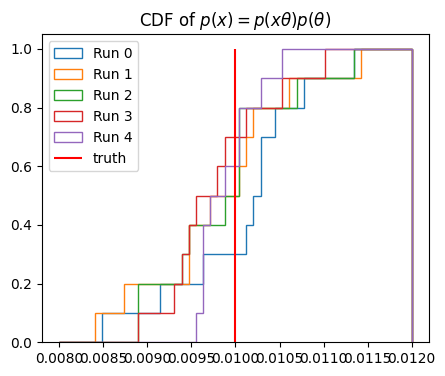

In [9]:
############################################
### plot CDF in one bin for illustration ###
############################################

donut_args["r_mean"] = 4.0
donut_args["gamma_scale"] = 2.
n_samples = 10_000
c_factor = 0.1 if MCMC else 50.
p = 0
data_dim = 2

name_add = ''
n_reps = range(0,5)

i_q_use =-2

bins = np.linspace(0.8*(1/n_bins_array[i_q_use]**2),1.2*(1/n_bins_array[i_q_use]**2),50)

fig, ax = plt.subplots(1,1, figsize = (5,4), sharex=True)

if approximate_gaussian_inference:
    save_dir = f'./models/CFM_VIB_k{c_factor}_cond'
    save_dir = save_dir + f'/{donut_shape}_{data_dim}d{add_str_save}_{donut_args["r_mean"]}rmean_{donut_args["gamma_scale"]}gamma/'+f'{n_samples}pts/'
    quantvals_nstatepis_arr_list_paths = [save_dir + f'{i}/quantvals_nstatepis_arr_list{name_add}.pkl' for i in n_reps] #(0,5)

    with open(save_dir + f'/0/n_bins_array{name_add}.npy', 'rb') as f:
        n_bins_array = np.load(f)

else:
    save_dir = f"./models/CFM_cond"
    save_dir = save_dir + f'/{donut_shape}_{data_dim}d{add_str_save}_{donut_args["r_mean"]}rmean_{donut_args["gamma_scale"]}gamma/'+f'{n_samples}pts/'        
    quantvals_nstatepis_arr_list_paths = [save_dir + f'{i}/AdamMCMC_models/{c_factor}sigma_1.0temp_0.001lr_50.0sigma_adam_dir_denom/quantvals_nstatepis_arr_list{name_add}.pkl' for i in n_reps]  #_linear.pkl

    with open(save_dir + f'/0/AdamMCMC_models/{c_factor}sigma_1.0temp_0.001lr_50.0sigma_adam_dir_denom/n_bins_array{name_add}.npy', 'rb') as f:
        n_bins_array = np.load(f)

for i_p, p in enumerate(quantvals_nstatepis_arr_list_paths):
    with open(p, 'rb') as file: 
        quantvals_nstatepis_arr_list = pickle.load(file) 

    quantvals = quantvals_nstatepis_arr_list[i_q_use][3,3]

    _,b,_, = plt.hist(quantvals.flatten(), density=True, label = f'Run {i_p}', bins = bins, cumulative=True, histtype='step')

plt.vlines(1/n_bins_array[i_q_use]**2,0,1, color='r', label = "truth")
plt.title(r'CDF of $p(x)=p(x\theta)p(\theta)$')
plt.legend(loc= 'upper left')

Text(0.5, 19.12222222222222, 'coverage')

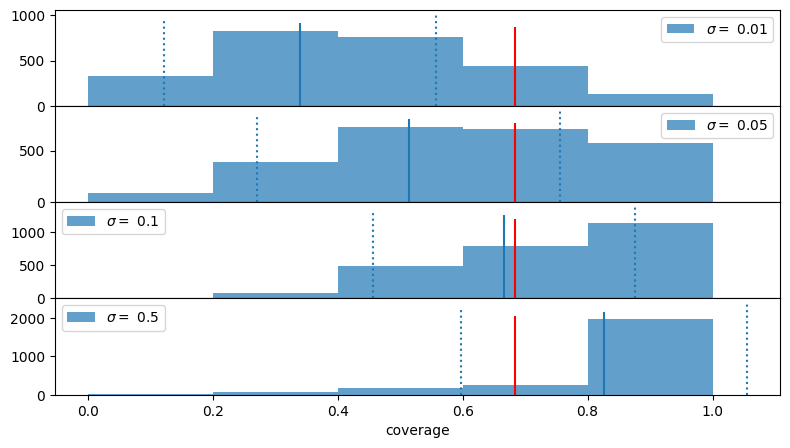

In [10]:
##########################################
### plot histograms of bin calibration ###
##########################################

donut_args["r_mean"] = 4.0
donut_args["gamma_scale"] = 2.
n_samples = 10_000
c_factors = [0.01, 0.05, 0.1, 0.5] if MCMC else [1.0,5.,10.,50.,100.] 
p = 0
data_dim = 2

i_q_use =-1

fig, ax = plt.subplots(len(c_factors),1, figsize = (8,len(c_factors)+.4), sharex=True)
if len(c_factors) == 1:
    ax = [ax]

for i_a, c_factor in enumerate(c_factors):
    if approximate_gaussian_inference:
        save_dir = f'./models/CFM_VIB_k{c_factor}_cond'
        save_dir = save_dir + f'/{donut_shape}_{data_dim}d{add_str_save}_{donut_args["r_mean"]}rmean_{donut_args["gamma_scale"]}gamma/'+f'{n_samples}pts/'
        quantvals_nstatepis_arr_list_paths = [save_dir + f'{i}/quantvals_nstatepis_arr_list.pkl' for i in range(0,5)]
    else:
        save_dir = f"./models/CFM_cond"
        save_dir = save_dir + f'/{donut_shape}_{data_dim}d{add_str_save}_{donut_args["r_mean"]}rmean_{donut_args["gamma_scale"]}gamma/'+f'{n_samples}pts/'     
        quantvals_nstatepis_arr_list_paths = [save_dir + f'{i}/AdamMCMC_models/{c_factor}sigma_1.0temp_0.001lr_50.0sigma_adam_dir_denom/quantvals_nstatepis_arr_list.pkl' for i in range(0,5)]

    for i_p, p in enumerate(quantvals_nstatepis_arr_list_paths):
        with open(p, 'rb') as file: 
            quantvals_nstatepis_arr_list = pickle.load(file) 
 
        if i_p == 0:
            q_out = [np.expand_dims(q, 0) for q in quantvals_nstatepis_arr_list]
        else:
            q_out = [np.concatenate((q_out[i_q], np.expand_dims(q, 0)), axis = 0) for i_q,q in enumerate(quantvals_nstatepis_arr_list)]
    

    quantvals = q_out[i_q_use]
    deviation = np.abs(np.mean(quantvals,1) - 1/(quantvals.shape[-1]*quantvals.shape[-2]))
    n_est_sum = np.mean(deviation/np.std(quantvals,1) <= 1, axis=0).flatten()

    ax[i_a].hist(n_est_sum, bins = np.arange(6)/5, label = f'$\sigma = $ {c_factor}' if MCMC else f'k = {c_factor}', alpha =0.7)
    ax[i_a].legend()
    ax[i_a].vlines(0.683, *ax[i_a].get_ylim(), color = 'red')
    ax[i_a].vlines(np.mean(n_est_sum), *ax[i_a].get_ylim(), color = 'C0', linestyle = '-')
    ax[i_a].vlines(np.mean(n_est_sum)-np.std(n_est_sum), *ax[i_a].get_ylim(), color = 'C0', linestyle = ':')
    ax[i_a].vlines(np.mean(n_est_sum)+np.std(n_est_sum), *ax[i_a].get_ylim(), color = 'C0', linestyle = ':')

fig.tight_layout()
fig.subplots_adjust(hspace=0)

#ax[len(c_factors)//2-1].set_ylabel('occurence')
ax[-1].set_xlabel('coverage')
#fig.savefig('./figs/coverage_over_k.pdf')


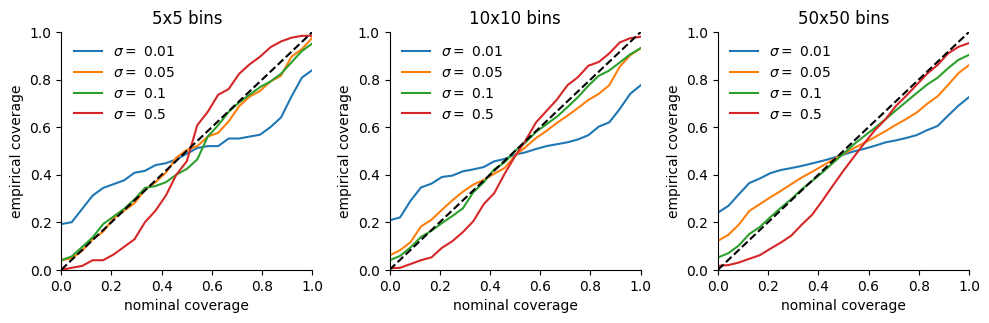

In [11]:
#######################################
### plot diagonal calibration plots ###
#######################################

alpha_quant = np.linspace(0,1,25)

donut_args["r_mean"] = 4.0
donut_args["gamma_scale"] = 2.
n_samples = 100_00
c_factors = [0.01, 0.05, 0.1, 0.5] if MCMC else [1.0,5.,10.,50.,100.] 
p = 0
data_dim = 2

i_q_uses = [0,1,2]
radial_bins_mins = [None]*3# [0,24,29]
radial_bins_maxs = [None]*3 #[24,29,49]
colors = [f'C{i}' for i in range(len(c_factors))]


quant_list_list_path = f'./figs/quant_list_list_{donut_args["gamma_scale"]}gamma.pkl' #_linear.pkl
with open(quant_list_list_path, 'rb') as file: 
    quant_list_list = pickle.load(file) 

if "linear" in quant_list_list_path:
    quantvals_true = []
    data_true = cart_to_nsphere(sampler.sample_data(10_000_000)[0])
    for quant_list in quant_list_list:
        quantvals_true.append(quantile_values_via_hist(quant_list, data_true))

fig, ax = plt.subplots(1,len(i_q_uses), figsize = (10,10/len(i_q_uses)), sharex=True)
if len(i_q_uses) == 1:
    ax = [ax]

for i_a, c_factor in enumerate(c_factors):
    if approximate_gaussian_inference:
        save_dir = f'./models/CFM_VIB_k{c_factor}_cond'
        save_dir = save_dir + f'/{donut_shape}_{data_dim}d{add_str_save}_{donut_args["r_mean"]}rmean_{donut_args["gamma_scale"]}gamma/'+f'{n_samples}pts/'
        quantvals_nstatepis_arr_list_paths = [save_dir + f'{i}/quantvals_nstatepis_arr_list.pkl' for i in n_reps] #(0,5)
    else:
        save_dir = f"./models/CFM_cond"
        save_dir = save_dir + f'/{donut_shape}_{data_dim}d{add_str_save}_{donut_args["r_mean"]}rmean_{donut_args["gamma_scale"]}gamma/'+f'{n_samples}pts/'        
        quantvals_nstatepis_arr_list_paths = [save_dir + f'{i}/AdamMCMC_models/{c_factor}sigma_1.0temp_0.001lr_50.0sigma_adam_dir_denom/quantvals_nstatepis_arr_list.pkl' for i in n_reps]  #_linear.pkl

    for i_p, p in enumerate(quantvals_nstatepis_arr_list_paths):
        with open(p, 'rb') as file: 
            quantvals_nstatepis_arr_list = pickle.load(file) 
 
        if i_p == 0:
            q_out = [np.expand_dims(q, 0) for q in quantvals_nstatepis_arr_list]
        else:
            q_out = [np.concatenate((q_out[i_q], np.expand_dims(q, 0)), axis = 0) for i_q,q in enumerate(quantvals_nstatepis_arr_list)]
    
    for i_p, i_q_use in enumerate(i_q_uses):
        radial_bins_min, radial_bins_max = radial_bins_mins[i_p], radial_bins_maxs[i_p]
        quantvals = q_out[i_q_use]

        if "linear" in quant_list_list_path:
            in_quantile = np.quantile(quantvals, alpha_quant, axis=1).T >= quantvals_true[i_q_use].T[:,:,np.newaxis,np.newaxis]
        else:
            in_quantile = np.quantile(quantvals, alpha_quant, axis=1).T >= 1/(quantvals.shape[-1]*quantvals.shape[-2])
        
        coverage = np.mean(in_quantile, 2)
        coverage = coverage[:,radial_bins_min:radial_bins_max]
        ax[i_p].plot(alpha_quant, coverage.mean((0,1)), color=colors[i_a], label = f'$\sigma = $ {c_factor}' if MCMC else f'k = {c_factor}')

        title_str = f'{n_bins_array[i_q_use]}x{n_bins_array[i_q_use]} bins'
        if radial_bins_min is not None:
            title_str = f'{radial_bins_max-radial_bins_min}x{n_bins_array[i_q_use]} bins' + f' $r \in$ ({quant_list_list[i_q_use][0][radial_bins_min]:.3}, {quant_list_list[i_q_use][0][radial_bins_max]:.3})'
        ax[i_p].set_title(title_str)

for a in ax:
    a.plot(alpha_quant, alpha_quant, linestyle = '--', color = 'black') 

    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.set_ylabel('empirical coverage')
    a.set_xlabel('nominal coverage')
    a.set_ylim(0,1)
    a.set_xlim(0,1)
    a.legend(loc = "upper left", frameon = False)

fig.tight_layout()
fig.subplots_adjust(hspace=0)

#ax[len(c_factors)//2-1].set_ylabel('occurence')
#fig.savefig('./figs/coverage_over_k_MCMC.pdf')


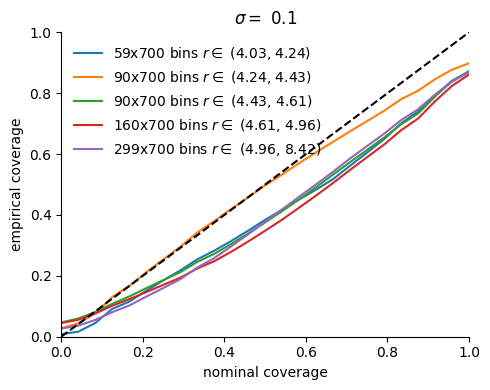

In [21]:
#######################################
### plot diagonal calibration plots ###
#######################################

alpha_quant = np.linspace(0,1,25)

donut_args["r_mean"] = 4.0
donut_args["gamma_scale"] = 2.
n_samples = 100_00
c_factor = 0.1 if MCMC else 10.
p = 0
data_dim = 2

i_q_uses = [-1,-1,-1,-1,-1]
radial_bins_mins = [1,60,150,240,400]
radial_bins_maxs = [60,150,240,400,699]
colors = [f'C{i}' for i in range(len(c_factors))]


quant_list_list_path = f'./figs/quant_list_list_{donut_args["gamma_scale"]}gamma_long_scaled.pkl' #_linear.pkl
with open(quant_list_list_path, 'rb') as file: 
    quant_list_list = pickle.load(file) 

if "linear" in quant_list_list_path:
    quantvals_true = []
    data_true = cart_to_nsphere(sampler.sample_data(10_000_000)[0])
    for quant_list in quant_list_list:
        quantvals_true.append(quantile_values_via_hist(quant_list, data_true))

fig, ax = plt.subplots(1,1, figsize = (5,4), sharex=True)

if approximate_gaussian_inference:
    save_dir = f'./models/CFM_VIB_k{c_factor}_cond'
    save_dir = save_dir + f'/{donut_shape}_{data_dim}d{add_str_save}_{donut_args["r_mean"]}rmean_{donut_args["gamma_scale"]}gamma/'+f'{n_samples}pts/'
    quantvals_nstatepis_arr_list_paths = [save_dir + f'{i}/quantvals_nstatepis_arr_list_long_scaled.pkl' for i in n_reps] #(0,5)
else:
    save_dir = f"./models/CFM_cond"
    save_dir = save_dir + f'/{donut_shape}_{data_dim}d{add_str_save}_{donut_args["r_mean"]}rmean_{donut_args["gamma_scale"]}gamma/'+f'{n_samples}pts/'        
    quantvals_nstatepis_arr_list_paths = [save_dir + f'{i}/AdamMCMC_models/{c_factor}sigma_1.0temp_0.001lr_50.0sigma_adam_dir_denom/quantvals_nstatepis_arr_list_long_scaled.pkl' for i in n_reps]  #_linear.pkl
    with open(save_dir + f'/0/AdamMCMC_models/{c_factor}sigma_1.0temp_0.001lr_50.0sigma_adam_dir_denom/n_bins_array_long_scaled.npy', 'rb') as f:
        n_bins_array = np.load(f)

for i_p, p in enumerate(quantvals_nstatepis_arr_list_paths):
    with open(p, 'rb') as file: 
        quantvals_nstatepis_arr_list = pickle.load(file) 

    if i_p == 0:
        q_out = [np.expand_dims(q, 0) for q in quantvals_nstatepis_arr_list]
    else:
        q_out = [np.concatenate((q_out[i_q], np.expand_dims(q, 0)), axis = 0) for i_q,q in enumerate(quantvals_nstatepis_arr_list)]

for i_p, i_q_use in enumerate(i_q_uses):
    radial_bins_min, radial_bins_max = radial_bins_mins[i_p], radial_bins_maxs[i_p]
    quantvals = q_out[i_q_use]

    if "linear" in quant_list_list_path:
        in_quantile = np.quantile(quantvals, alpha_quant, axis=1).T >= quantvals_true[i_q_use].T[:,:,np.newaxis,np.newaxis]
    else:
        in_quantile = np.quantile(quantvals, alpha_quant, axis=1).T >= 1/(quantvals.shape[-1]*quantvals.shape[-2])
    
    coverage = np.mean(in_quantile, 2)
    coverage = coverage[:,radial_bins_min:radial_bins_max]

    title_str = f'{n_bins_array[i_q_use]}x{n_bins_array[i_q_use]} bins'
    if radial_bins_min is not None:
        title_str = f'{radial_bins_max-radial_bins_min}x{n_bins_array[i_q_use]} bins' + f' $r \in$ ({quant_list_list[i_q_use][0][radial_bins_min]:.3}, {quant_list_list[i_q_use][0][radial_bins_max]:.3})'
    ax.plot(alpha_quant, coverage.mean((0,1)), label = title_str)

ax.set_title(f'$\sigma = $ {c_factor}' if MCMC else f'k = {c_factor}')

ax.plot(alpha_quant, alpha_quant, linestyle = '--', color = 'black') 

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('empirical coverage')
ax.set_xlabel('nominal coverage')
ax.set_ylim(0,1)
ax.set_xlim(0,1)
ax.legend(loc = "upper left", frameon = False)

fig.tight_layout()
fig.subplots_adjust(hspace=0)

#ax[len(c_factors)//2-1].set_ylabel('occurence')
#fig.savefig('./figs/coverage_over_k_MCMC.pdf')


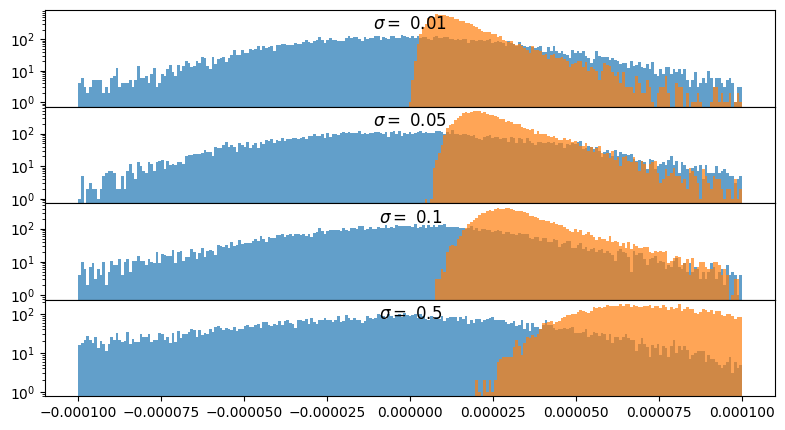

In [13]:
####################################################################
### plot histograms of uncertainty estimates and true deviaitons ###
####################################################################

r_test = 4.0
n_samples = 10_000
c_factors = [0.01, 0.05, 0.1, 0.5] if MCMC else [1.0,10.,100.] 
p = 0

i_q =-1

fig, axs = plt.subplots(len(c_factors), figsize = (8,len(c_factors)+0.4), sharex=True)
if len(c_factors) == 1:
    axs = [axs]

for i_a, c_factor in enumerate(c_factors):
    if approximate_gaussian_inference:
        save_dir = f'./models/CFM_VIB_k{c_factor}_cond'
        save_dir = save_dir + f'/{donut_shape}_{data_dim}d{add_str_save}_{donut_args["r_mean"]}rmean_{donut_args["gamma_scale"]}gamma/'+f'{n_samples}pts/'
        quantvals_nstatepis_arr_list_paths = [save_dir + f'{i}/quantvals_nstatepis_arr_list.pkl' for i in n_reps] #(0,5)
    else:
        save_dir = f"./models/CFM_cond"
        save_dir = save_dir + f'/{donut_shape}_{data_dim}d{add_str_save}_{donut_args["r_mean"]}rmean_{donut_args["gamma_scale"]}gamma/'+f'{n_samples}pts/'        
        quantvals_nstatepis_arr_list_paths = [save_dir + f'{i}/AdamMCMC_models/{c_factor}sigma_1.0temp_0.001lr_50.0sigma_adam_dir_denom/quantvals_nstatepis_arr_list.pkl' for i in n_reps]  #_linear.pkl

    for i_p, p in enumerate(quantvals_nstatepis_arr_list_paths):
        with open(p, 'rb') as file: 
            quantvals_nstatepis_arr_list = pickle.load(file) 

        if i_p == 0:
            q_out = [np.expand_dims(q, 0) for q in quantvals_nstatepis_arr_list]
        else:
            q_out = [np.concatenate((q_out[i_q], np.expand_dims(q, 0)), axis = 0) for i_q,q in enumerate(quantvals_nstatepis_arr_list)]

    quantvals = q_out[i_q]
    deviation = (np.mean(quantvals,1) - 1/(quantvals.shape[-1]*quantvals.shape[-2])).flatten()
    std = np.std(quantvals,1).flatten()

    #_,b,_ = axs[i_a].hist(deviation, bins = np.linspace(-0.0005,0.0035,250), label = f'deviation of predicitons', alpha =0.7)
    _,b,_ = axs[i_a].hist(deviation, bins = np.linspace(-0.0001,0.0001,250), label = f'deviation of predicitons', alpha =0.7)
    axs[i_a].hist(std, bins = b, label = f'predicted standard deviation', alpha =0.7)
    axs[i_a].set_yscale('log')
    axs[i_a].set_title(f'$\sigma = $ {c_factor}' if MCMC else f'k = {c_factor}', y=1.0, pad=-14)

fig.tight_layout()
fig.subplots_adjust(hspace=0)

#axs[0].legend()
#axs[2].set_ylabel('occurence')
#fig.savefig('./figs/deviations_over_k.pdf')


/tmp/ipykernel_16135/3921811069.py:36: RuntimeWarning: invalid value encountered in divide
  n_est_sum = np.sum(np.mean(quantvals,0)**2/np.std(quantvals,0)**2)


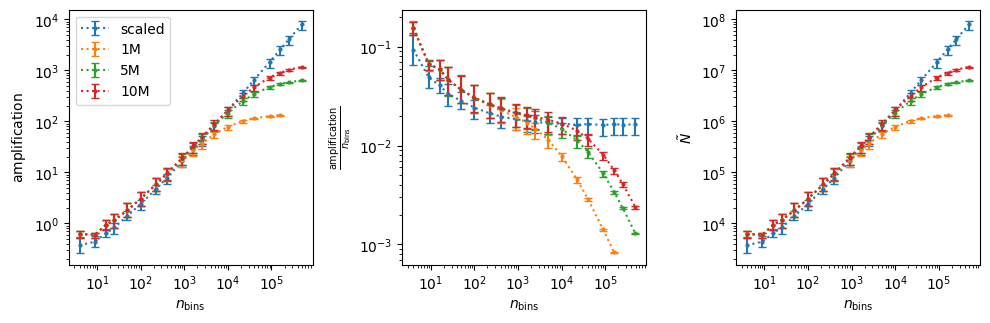

In [14]:
##################################################
### plot amplification over the number of bins ### --- Add multiple training set sizes
##################################################

c_factor = 0.1 if MCMC else 10.
name_adds = ["_long_scaled", "_long_1M", "_long_5M", "_long_10M" ]
skip_lasts = [None, -3, -1, -1]

fig, ax = plt.subplots(1,3, figsize = (10,10/3))

for i_name, name_add in enumerate(name_adds):
    if approximate_gaussian_inference:
        save_dir = f'./models/CFM_VIB_k{c_factor}_cond'
        save_dir = save_dir + f'/{donut_shape}_{data_dim}d{add_str_save}_{donut_args["r_mean"]}rmean_{donut_args["gamma_scale"]}gamma/'+f'{n_samples}pts/'
        quantvals_nstatepis_arr_list_paths = [save_dir + f'{i}/quantvals_nstatepis_arr_list{name_add}.pkl' for i in n_reps] #(0,5)

        with open(save_dir + f'/0/n_bins_array{name_add}.npy', 'rb') as f:
            n_bins_array = np.load(f)
    
    else:
        save_dir = f"./models/CFM_cond"
        save_dir = save_dir + f'/{donut_shape}_{data_dim}d{add_str_save}_{donut_args["r_mean"]}rmean_{donut_args["gamma_scale"]}gamma/'+f'{n_samples}pts/'        
        quantvals_nstatepis_arr_list_paths = [save_dir + f'{i}/AdamMCMC_models/{c_factor}sigma_1.0temp_0.001lr_50.0sigma_adam_dir_denom/quantvals_nstatepis_arr_list{name_add}.pkl' for i in n_reps]  #_linear.pkl

        with open(save_dir + f'/0/AdamMCMC_models/{c_factor}sigma_1.0temp_0.001lr_50.0sigma_adam_dir_denom/n_bins_array{name_add}.npy', 'rb') as f:
            n_bins_array = np.load(f)

    amplification = np.zeros((len(quantvals_nstatepis_arr_list_paths), len(n_bins_array)))
    n_samples_estimate= np.zeros((len(quantvals_nstatepis_arr_list_paths), len(n_bins_array)))

    for i_p, p in enumerate(quantvals_nstatepis_arr_list_paths):
        with open(p, 'rb') as file: 
            quantvals_nstatepis_arr_list = pickle.load(file) 

        for i_q, quantvals in enumerate(quantvals_nstatepis_arr_list):
            n_est_sum = np.sum(np.mean(quantvals,0)**2/np.std(quantvals,0)**2)
            amplification[i_p, i_q] = 1/n_samples*n_est_sum

            n_samples_estimate[i_p, i_q] = n_est_sum

    n_bins_array = n_bins_array[:skip_lasts[i_name]]
    amplification = amplification[:,:skip_lasts[i_name]]
    n_samples_estimate = n_samples_estimate[:,:skip_lasts[i_name]]

    x = n_bins_array**2

    y_mean = amplification.mean(0)
    y_err_lower = y_mean - amplification.min(0)
    y_err_upper = amplification.max(0) - y_mean

    ax[0].errorbar(x, y_mean, (y_err_lower, y_err_upper), linestyle=':', capsize =3, marker = 'o', markersize = 2, label = name_add.split('_')[2])
    ax[1].errorbar(x, y_mean/x, (y_err_lower/x, y_err_upper/x), linestyle=':', capsize =3, marker = 'o', markersize = 2)

    y_mean = n_samples_estimate.mean(0)
    y_err_lower = y_mean - n_samples_estimate.min(0)
    y_err_upper = n_samples_estimate.max(0) - y_mean

    ax[2].errorbar(x, y_mean, (y_err_lower, y_err_upper), linestyle=':', capsize =3, marker = 'o', markersize = 2)

ax[0].legend()
ax[0].set_xscale('log')
ax[0].set_yscale('log')
#ax[0].set_ylim(0.3,1500)
ax[0].set_xlabel(r'$n_\mathrm{bins}$')
ax[0].set_ylabel(r'$\mathrm{amplification}$')

ax[1].set_xscale('log')
ax[1].set_yscale('log')
#ax[1].set_ylim(0.001,.2)
ax[1].set_xlabel(r'$n_\mathrm{bins}$')
ax[1].set_ylabel(r'$\frac{\mathrm{amplification}}{n_\mathrm{bins}}$')


ax[2].set_xscale('log')
ax[2].set_yscale('log')
#ax[2].set_ylim(None,1e8)
ax[2].set_xlabel(r'$n_\mathrm{bins}$')
ax[2].set_ylabel(r'$\tilde{N}$')

fig.tight_layout()

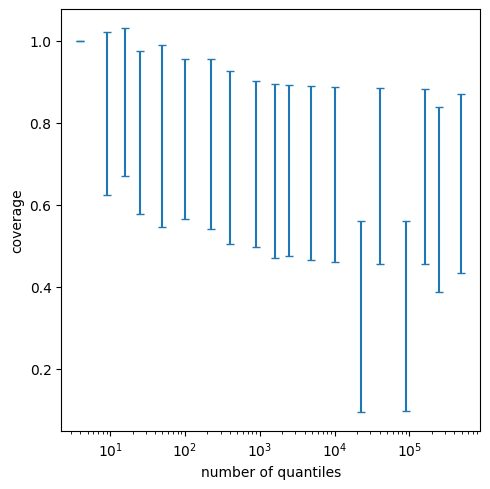

In [15]:
###############################################################
### plot scaling of the calibration with the number of bins ###
###############################################################

c_factor = 0.1 if MCMC else 10.
name_add = "_long_scaled"

if approximate_gaussian_inference:
    save_dir = f'./models/CFM_VIB_k{c_factor}_cond'
    save_dir = save_dir + f'/{donut_shape}_{data_dim}d{add_str_save}_{donut_args["r_mean"]}rmean_{donut_args["gamma_scale"]}gamma/'+f'{n_samples}pts/'
    quantvals_nstatepis_arr_list_paths = [save_dir + f'{i}/quantvals_nstatepis_arr_list{name_add}.pkl' for i in n_reps] #(0,5)

    with open(save_dir + f'/0/n_bins_array{name_add}.npy', 'rb') as f:
        n_bins_array = np.load(f)

else:
    save_dir = f"./models/CFM_cond"
    save_dir = save_dir + f'/{donut_shape}_{data_dim}d{add_str_save}_{donut_args["r_mean"]}rmean_{donut_args["gamma_scale"]}gamma/'+f'{n_samples}pts/'        
    quantvals_nstatepis_arr_list_paths = [save_dir + f'{i}/AdamMCMC_models/{c_factor}sigma_1.0temp_0.001lr_50.0sigma_adam_dir_denom/quantvals_nstatepis_arr_list{name_add}.pkl' for i in n_reps]  #_linear.pkl

    with open(save_dir + f'/0/AdamMCMC_models/{c_factor}sigma_1.0temp_0.001lr_50.0sigma_adam_dir_denom/n_bins_array{name_add}.npy', 'rb') as f:
        n_bins_array = np.load(f)

quantvals_models =[]

for i_p, p in enumerate(quantvals_nstatepis_arr_list_paths):
    with open(p, 'rb') as file: 
        quantvals_nstatepis_arr_list = pickle.load(file) 

    if i_p == 0:
        q_out = [np.expand_dims(q, 0) for q in quantvals_nstatepis_arr_list]
    else:
        q_out = [np.concatenate((q_out[i_q], np.expand_dims(q, 0)), axis = 0) for i_q,q in enumerate(quantvals_nstatepis_arr_list)]

fig, ax = plt.subplots(1,1, figsize = (5,5))

coverage_mean, coverage_std = np.zeros(len(q_out)),np.zeros(len(q_out))
for i_q, quantvals in enumerate(q_out):
    deviation = np.abs(np.mean(quantvals,1) - 1/(quantvals.shape[-1]*quantvals.shape[-2]))
    n_est_sum = np.mean(deviation/np.std(quantvals,1) <= 1, axis=0)
    coverage_mean[i_q] = np.mean(n_est_sum)
    coverage_std[i_q] = np.std(n_est_sum)

ax.errorbar(n_bins_array**2, coverage_mean, yerr = coverage_std, label = f'{n_samples} pts', linestyle = '', capsize = 3)
ax.set_xscale('log')
ax.set_xlabel('number of quantiles')
ax.set_ylabel('coverage')
fig.tight_layout()
#fig.savefig(save_dir + 'coverage.pdf')

0it [00:00, ?it/s]/beegfs/desy/user/bierings/Bayesiamplify/src/dataloader.py:7: RuntimeWarning: divide by zero encountered in divide
  out = np.arctan(1/x)
19it [01:25,  4.53s/it]
19it [01:34,  4.98s/it]
19it [01:23,  4.41s/it]
19it [01:04,  3.38s/it]
19it [01:21,  4.29s/it]


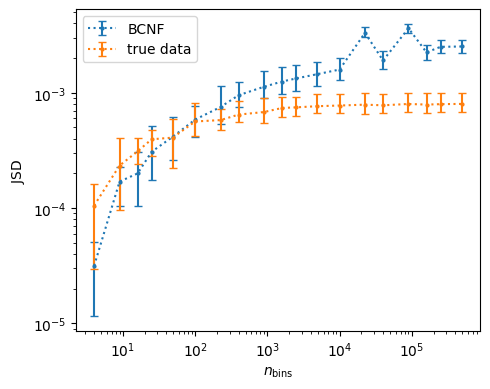

In [16]:
######################################################################
### compare to JSD bases amplification by estimating the "closure" ### -- ToDo
######################################################################

def quantile_JSD(data, data_true = None):
    n_quant = np.prod(data.shape)
    
    p = 1/n_quant if data_true is None else data_true
    q = data
    
    tmp1 = p*np.log(2*p/(p+q)) 
    tmp2 = q*np.log(2*q/(p+q))
    tmp = np.nan_to_num(tmp1, nan = 0, posinf = 0, neginf = 0) + np.nan_to_num(tmp2, nan = 0, posinf = 0, neginf = 0)

    jsd = 0.5*np.sum(tmp)  
    return jsd

c_factor = 0.1 if MCMC else 10.
name_add = "_long_scaled"

fig, ax = plt.subplots(1,1, figsize = (5,4))

quant_list_list_path = f'./figs/quant_list_list_{donut_args["gamma_scale"]}gamma{name_add}.pkl' #_linear.pkl
with open(quant_list_list_path, 'rb') as file: 
    quant_list_list = pickle.load(file) 

if approximate_gaussian_inference:
    save_dir = f'./models/CFM_VIB_k{c_factor}_cond'
    save_dir = save_dir + f'/{donut_shape}_{data_dim}d{add_str_save}_{donut_args["r_mean"]}rmean_{donut_args["gamma_scale"]}gamma/'+f'{n_samples}pts/'
    quantvals_nstatepis_arr_list_paths = [save_dir + f'{i}/quantvals_nstatepis_arr_list{name_add}.pkl' for i in n_reps] #(0,5)

    with open(save_dir + f'/0/n_bins_array{name_add}.npy', 'rb') as f:
        n_bins_array = np.load(f)

else:
    save_dir = f"./models/CFM_cond"
    save_dir = save_dir + f'/{donut_shape}_{data_dim}d{add_str_save}_{donut_args["r_mean"]}rmean_{donut_args["gamma_scale"]}gamma/'+f'{n_samples}pts/'        
    quantvals_nstatepis_arr_list_paths = [save_dir + f'{i}/AdamMCMC_models/{c_factor}sigma_1.0temp_0.001lr_50.0sigma_adam_dir_denom/quantvals_nstatepis_arr_list{name_add}.pkl' for i in n_reps]  #_linear.pkl

    with open(save_dir + f'/0/AdamMCMC_models/{c_factor}sigma_1.0temp_0.001lr_50.0sigma_adam_dir_denom/n_bins_array{name_add}.npy', 'rb') as f:
        n_bins_array = np.load(f)

assert len(quant_list_list)==len(n_bins_array)

JSD_BCNF, JSD_truth = np.zeros((len(quantvals_nstatepis_arr_list_paths), len(n_bins_array))), np.zeros((len(quantvals_nstatepis_arr_list_paths), len(n_bins_array)))

name_add2 = '_VIB' if approximate_gaussian_inference else '_MCMC'
if f'JSD_BCNF{name_add}{name_add2}.npy' in os.listdir('./figs/'):
    JSD_BCNF = np.load('./figs/' + f'JSD_BCNF{name_add}{name_add2}.npy')
    JSD_truth = np.load('./figs/' + f'JSD_truth{name_add}{name_add2}.npy')

else:
    for i_p, p in enumerate(quantvals_nstatepis_arr_list_paths):
        save_dir_temp = ''.join([s+'/' for s in p.split('/')[:-1]])

        with open(p, 'rb') as file: 
            quantvals_nstatepis_arr_list = pickle.load(file) 

        for i_q, quantvals in tqdm(enumerate(quantvals_nstatepis_arr_list)):
            n_samples_estimate = np.sum(np.nan_to_num(np.mean(quantvals,0)**2/np.std(quantvals,0)**2)).astype(int)
            if n_samples_estimate > 0:
                truth_data_compare = sampler.sample_data(n_samples_estimate)[0]
                quantvals_truth_compare = quantile_values_via_hist(quant_list_list[i_q], cart_to_nsphere(truth_data_compare))

                JSD_BCNF[i_p, i_q] = quantile_JSD(np.mean(quantvals,0))
                JSD_truth[i_p, i_q] = quantile_JSD(quantvals_truth_compare)
            else:
                JSD_BCNF[i_p, i_q] = 0
                JSD_truth[i_p, i_q] = 0

    np.save(f'./figs/JSD_BCNF{name_add}{name_add2}.npy', JSD_BCNF)
    np.save(f'./figs/JSD_truth{name_add}{name_add2}.npy', JSD_truth)

x = n_bins_array**2

y_mean = JSD_BCNF.mean(0)
y_err_lower = y_mean - JSD_BCNF.min(0)
y_err_upper = JSD_BCNF.max(0) - y_mean

ax.errorbar(x, y_mean, (y_err_lower, y_err_upper), linestyle=':', capsize =3, marker = 'o', markersize = 2, label = 'BCNF')

y_mean = JSD_truth.mean(0)
y_err_lower = y_mean - JSD_truth.min(0)
y_err_upper = JSD_truth.max(0) - y_mean

ax.errorbar(x, y_mean, (y_err_lower, y_err_upper), linestyle=':', capsize =3, marker = 'o', markersize = 2, label = 'true data')

ax.legend()
ax.set_xscale('log')
ax.set_yscale('log')
#ax[0].set_ylim(0.3,1200)
ax.set_xlabel(r'$n_\mathrm{bins}$')
ax.set_ylabel(r'$\mathrm{JSD}$')

fig.tight_layout()
